In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import OpenEXR
import Imath
import array


# %pylab inline
class MidpointNormalize(mpl.colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
        
def read_exr(filename):
    file = OpenEXR.InputFile(filename)
    dw = file.header()['dataWindow']
    size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

    # Read the three color channels as 32-bit floats
    FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
    (R,G,B) = [array.array('f', file.channel(Chan, FLOAT)).tolist() for Chan in ("R", "G", "B")]

    # Normalize the data to the range [0, 1]
    img = np.zeros((size[1], size[0], 3), dtype=np.float32)
    img[:,:,0] = np.array(R).reshape(size[1], size[0]) / max(R)
    img[:,:,1] = np.array(G).reshape(size[1], size[0]) / max(G)
    img[:,:,2] = np.array(B).reshape(size[1], size[0]) / max(B)

    return img


## Figure 5
Adjusted captions and plot structure

Data:
- maneki4 / sensor1
- kettle4 / sensor3

In [308]:
pths = [
     "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/maneki4/fig4/iter_1_3_out.exr",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/maneki4/test_2/grad/sensor3_sigmaT50.0_VaeSub_delta5_FD.npy",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/maneki4/test_2/grad/sensor3_sigmaT50.0_VaeSub_delta5_Ours.npy",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/maneki4/test_2/grad/sensor3_sigmaT50.0_VaeSub_delta5_absdiff.npy",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/kettle4/2024-08-01 17:06:25.613327/iter_1_1_out.exr",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/kettle4/test_2/grad/sensor1_sigmaT50.0_VaeSub_delta5_FD.npy",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/kettle4/test_2/grad/sensor1_sigmaT50.0_VaeSub_delta5_Ours.npy",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/kettle4/test_2/grad/sensor1_sigmaT50.0_VaeSub_delta5_absdiff.npy",

]

text_cols = ['(a) Primal Rendering',
            '(b) FD Reference',
            '(c) Ours',
            '(d) Abs. Diff.'
            ]
space_cols = [
    0.12,
    0.46/4,
    0.1,
    0.095,
]
text_rows = ['Maneki',
            'Kettle',
            ]
space_rows = [
    0.77,
    0.8,
]

list_imgs = []
for pth in pths:
    if pth.endswith('exr'):
        # Load exr
        img = read_exr(pth)
    elif pth.endswith('npy'):
        # Apply colormap
        img = np.load(pth)
    list_imgs.append(img)

0.017022103 6.795247e-05
0.018459935517360766 6.406796701724038e-05
0.021277418 0.00018011552
0.02278672220806281 0.00015904872404365631


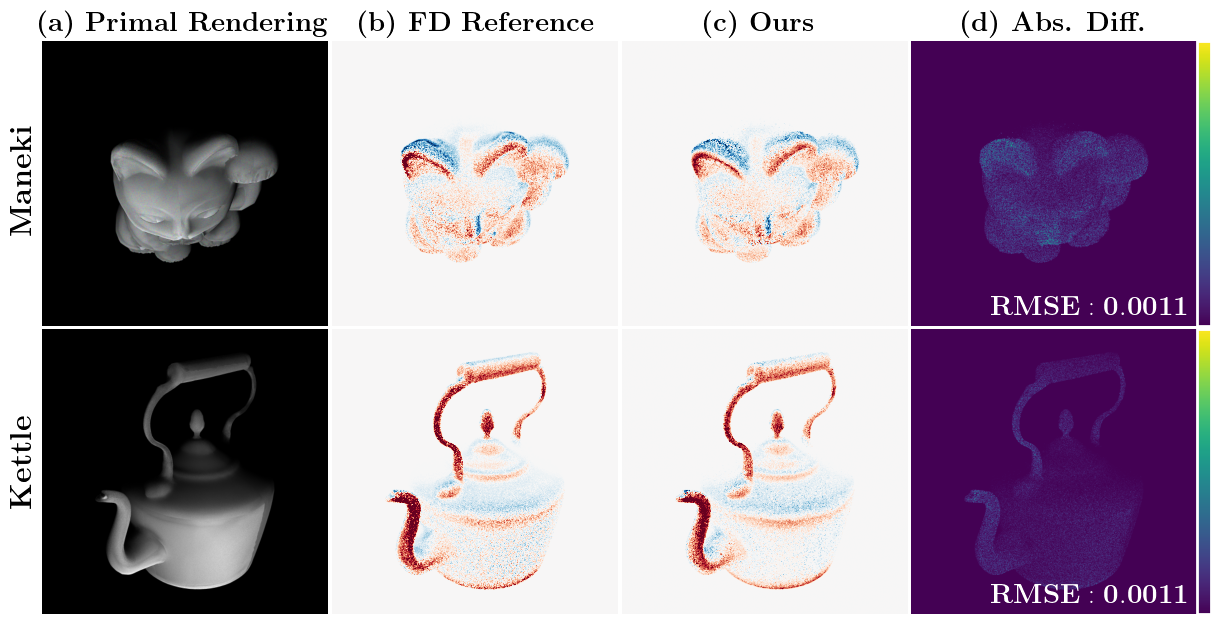

In [309]:
n_rows = 2
n_cols = 4
size = 3
thres = 0.006
# Set up matplotlib to use LaTeX for all text
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "font.size": 18,
    "text.color": 'black',
    # 'axes.labelcolor': 'black',
})


# Create figure and grid
fig = plt.figure(figsize=(size*n_cols,size*n_rows))
gs = fig.add_gridspec(n_rows, n_cols,
                      width_ratios=[1,1,1,1.05],
                      height_ratios=[1,]*n_rows,
                     )

# Create subplots
for row in range(n_rows):
    for col in range(n_cols):
        if col == 0:
            ax = fig.add_subplot(gs[row, col])
            ax.imshow(list_imgs[row*n_cols + col])
            ax.axis('off')
        else:
            img = list_imgs[row*n_cols + col]
            cmax = max(img.max(),img.min())
            # print(cmax)
            cmax = min(cmax,thres)
            norm = MidpointNormalize(vmin=-cmax,vmax=cmax,midpoint=0.0)
            # plt.imshow(grad_fd,cmap='RdBu_r',norm=norm)
            
            ax = fig.add_subplot(gs[row, col])
            if col == n_cols - 1:
                im = ax.imshow(img,cmap='viridis',)
                divider = make_axes_locatable(ax)
                cax = divider.append_axes('right', size='5%', pad=0.01)
                cb = fig.colorbar(im, cax=cax, orientation='vertical',ticks=[])
                                
                # Change the outline color
                cb.outline.set_edgecolor('white')  # or any color you prefer
                cb.outline.set_linewidth(2)  # adjust line width if needed

                rmse = np.sqrt((img ** 2).mean()) #np.mean((grad-fd)**2))
                ax.text(500,500,r'$\mathbf{RMSE:' + f"{rmse:.4f}" + '}$',fontsize=20 ,ha='right', va='bottom',color='white')
            else:
                # img *= 3
                print(img.max(), img.mean())
                ax.imshow(img,cmap='RdBu_r',norm=norm)
            ax.axis('off')  # Turn off axes for images

# Add column captions with LaTeX formatting
for col in range(n_cols):
    fig.text(col/4 + space_cols[col], 1.03, r'$\textbf{' + text_cols[col] + '}$', 
             ha='center', va='center',fontsize=20)

    # fig.text((col+0.46) / 4, 1.03, r'$\mathbf{Column \;' + str(col+1) + '}$', ha='center', va='center')

# Add row captions with LaTeX formatting
for row in range(n_rows):
    fig.text(-0.025, space_rows[row] - row*0.5, r'$\textbf{' + text_rows[row] + '}$', 
             ha='left', va='center', rotation=90,fontsize=22)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(left=0.0,top=1.0,hspace=0.01, wspace=0.0)

plt.savefig(f'figures/fig5.png',bbox_inches='tight') 
plt.savefig(f'figures/fig5.pdf',bbox_inches='tight') 
plt.show()

## Figure 4
Data: 
- kettle2 / sensor4 / sigmaT50,albedo0.9
- botijo3 / sensor1 / sigmaT50,albedo0.9

**TODO: fix artifact in forward rendering bf. moving on**

In [306]:
pths = [
     "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/kettle2/2024-08-01 17:46:18.877081/iter_1_4_out.exr",
    # "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/kettle2/test_2/grad/sensor4_albedo0.800000011920929_VaeSub_delta0.05_FD.npy",
    # "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/kettle2/test_2/grad/sensor4_albedo0.800000011920929_VaeSub_delta0.05_Ours.npy",
    # "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/kettle2/test_2/grad/sensor4_albedo0.800000011920929_VaeSub_delta0.05_absdiff.npy",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/kettle2/test_2/grad/sensor4_albedo0.8899999856948853_VaeSub_delta0.05_FD.npy",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/kettle2/test_2/grad/sensor4_albedo0.8899999856948853_VaeSub_delta0.05_Ours.npy",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/kettle2/test_2/grad/sensor4_albedo0.8899999856948853_VaeSub_delta0.05_absdiff.npy",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/botijo3/2024-08-01 17:59:53.463934/iter_1_1_out.exr",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/botijo3/test_2/grad/sensor1_albedo0.800000011920929_VaeSub_delta0.05_FD.npy",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/botijo3/test_2/grad/sensor1_albedo0.800000011920929_VaeSub_delta0.05_Ours.npy",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/grad/results/botijo3/test_2/grad/sensor1_albedo0.800000011920929_VaeSub_delta0.05_absdiff.npy",

]

text_cols = ['(a) Primal Rendering',
            '(b) FD Reference',
            '(c) Ours',
            '(d) Abs. Diff.'
            ]
space_cols = [
    0.12,
    0.46/4,
    0.1,
    0.095,
]
text_rows = ['Kettle',
            'Botijo',
            ]
space_rows = [
    0.77,
    0.8,
]

list_imgs = []
for pth in pths:
    if pth.endswith('exr'):
        # Load exr
        img = read_exr(pth)
    elif pth.endswith('npy'):
        # Apply colormap
        img = np.load(pth)
    list_imgs.append(img)

2.334638 0.058891304
1.686475435892741 0.05456547431692838
3.2042484 0.033175953
3.8095086415608725 0.03192842650552923


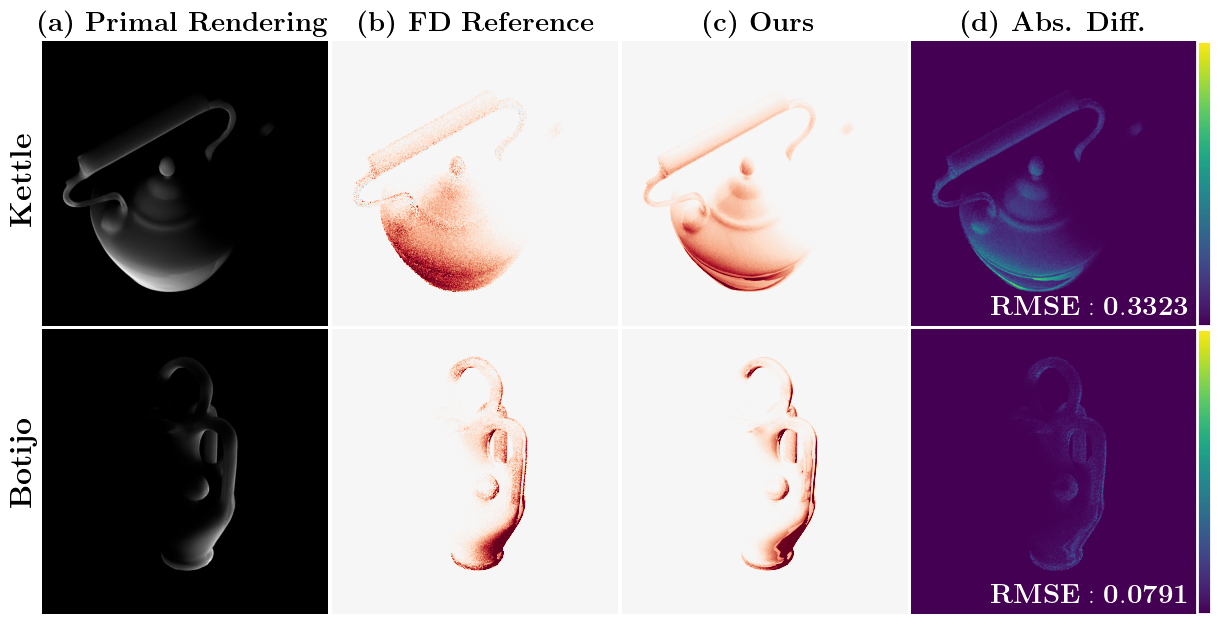

In [307]:
n_rows = 2
n_cols = 4
size = 3
thres = 1.1
# Set up matplotlib to use LaTeX for all text
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "font.size": 18,
    "text.color": 'black',
    # 'axes.labelcolor': 'black',
})


# Create figure and grid
fig = plt.figure(figsize=(size*n_cols,size*n_rows))
gs = fig.add_gridspec(n_rows, n_cols,
                      width_ratios=[1,1,1,1.05],
                      height_ratios=[1,]*n_rows,
                     )

# Create subplots
for row in range(n_rows):
    for col in range(n_cols):
        if col == 0:
            ax = fig.add_subplot(gs[row, col])
            ax.imshow(list_imgs[row*n_cols + col])
            ax.axis('off')
        else:
            img = list_imgs[row*n_cols + col]
            cmax = max(img.max(),img.min())
            # print(cmax)
            cmax = min(cmax,thres)
            norm = MidpointNormalize(vmin=-cmax,vmax=cmax,midpoint=0.0)
            
            ax = fig.add_subplot(gs[row, col])
            if col == n_cols - 1:
                im = ax.imshow(img,cmap='viridis',)
                divider = make_axes_locatable(ax)
                cax = divider.append_axes('right', size='5%', pad=0.01)
                cb = fig.colorbar(im, cax=cax, orientation='vertical',ticks=[])
                                
                # Change the outline color
                cb.outline.set_edgecolor('white')  # or any color you prefer
                cb.outline.set_linewidth(2)  # adjust line width if needed

                rmse = np.sqrt((img ** 2).mean()) #np.mean((grad-fd)**2))
                ax.text(500,500,r'$\mathbf{RMSE:' + f"{rmse:.4f}" + '}$',fontsize=20 ,ha='right', va='bottom',color='white')
            else:
                # if col == 1:
                #     img *= 3
                print(img.max(), img.mean())
                ax.imshow(img,cmap='RdBu_r',norm=norm)
            ax.axis('off')  # Turn off axes for images

# Add column captions with LaTeX formatting
for col in range(n_cols):
    fig.text(col/4 + space_cols[col], 1.03, r'$\textbf{' + text_cols[col] + '}$', 
             ha='center', va='center',fontsize=20)

    # fig.text((col+0.46) / 4, 1.03, r'$\mathbf{Column \;' + str(col+1) + '}$', ha='center', va='center')

# Add row captions with LaTeX formatting
for row in range(n_rows):
    fig.text(-0.025, space_rows[row] - row*0.5, r'$\textbf{' + text_rows[row] + '}$', 
             ha='left', va='center', rotation=90,fontsize=22)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(left=0.0,top=1.0,hspace=0.01, wspace=0.0)


# plt.savefig(f'figures/fig4.png',bbox_inches='tight')
# plt.savefig(f'figures/fig4.pdf',bbox_inches='tight')
plt.show()